In [1]:
"""
    Returns a cleaned X and y dataset to be used for classification.
"""
import os
import cv2
import sys
import numpy as np
from PIL import Image
import tensorflow as tf
from scipy import misc
from matplotlib.image import imread
import matplotlib.pyplot as plt
import keras

import joblib
from sklearn.model_selection import train_test_split, cross_validate

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model


from random import randint
import cv2
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import optimizers



In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Uncomment the following to check whether you have access to a GPU in Google Colab
# See further instructione below.
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU') 

[]

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from packaging import version
import sklearn
import tensorflow as tf
from tensorflow.keras.models import load_model
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow
from tensorflow.keras.models import model_from_json
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print
tensorflow_version = tf.__version__
if version.parse(tensorflow_version) < version.parse("2.2.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.2 or later (e.g. 2.4)".format(tensorflow_version))
elif version.parse(tensorflow_version) < version.parse("2.4.0"):
    print("Tensorflow version is <2.4. This will likely work but we recommend updating to 2.4".format(tensorflow_version))
else:
    print("Looks good. You may continue :)")

Looks good. You may continue :)


In [5]:
PATH=r"C:\Users\Jeroen Gijsbers\OneDrive - TU Eindhoven\Uni\Master\Jaar 1\Kwartiel 3\2AMV10 - Visual Analytics\Project\2AMV10-group-16"
PATH_m = r"/content/drive/MyDrive/-Univ/2AMV10 Visual Analytics/2AMV10-group-16"
IMG_SIZE  = 160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
IMAGE_CHANNEL = 3
stop_training = False

Helper functions

In [6]:
def process_img(sample):
  """Function to process the large images to a more handle-able format
  
     returns: """
  try:
    # print(sample.shape)
    sample = np.array(sample)
    sample = sample / 255.
    sample = cv2.resize(sample, (IMG_SIZE, IMG_SIZE))
    return sample.reshape(IMG_SIZE, IMG_SIZE, IMAGE_CHANNEL)
  except ValueError or AttributeError:
    print(sample, "returned an error")


def read_data():
    """
        Reads the images and returns them as arrays X and y

        returns: X      array containing np-array-representation of images
                 y      array containing corresponding labels
    """
    #print(os.curdir)
    #os.chdir('../data/trainingData/TrainingImages')
    X = []
    y = []
    labels = []
    sys.path.insert(0, PATH_m)

    path = "/content/drive/MyDrive/-Univ/2AMV10/2AMV10-group-16/data/trainingData/TrainingImages"
    i = 0
    limit = 100000
    for label in [name for name in os.listdir(path) if os.path.isdir(f"{path}/{name}")]:
        print(label)
        labels.append(label)
        for image in [name for name in os.listdir(f"{path}/{label}")]:
            if image.endswith('.db'):
              pass
            else:
              # print(f"{path}/{label}/{image}")
              X.append(process_img(cv2.imread(f"{path}/{label}/{image}")))
              # print(label)
              y.append(label)
              i+= 1
            if i == limit:
                break
        if i == limit:
            break
    return np.array(X), y, labels#.reshape(50, 256*256), y, labels


# Helper function for user feedback
def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

def show_images(grayscale=False, display_test=False):
        """
            Shows 10 random images from the dataset
        """
        def plot_images(X, y, grayscale=False, display_test=False):
            fig, axes = plt.subplots(1, len(X), figsize=(15,30))
            for n in range(len(X)):
                if grayscale:
                    axes[n].imshow(X[n], cmap='gray')
                else:
                    axes[n].imshow(X[n])
                # print(f"1: {y[n]}")
                # print(f"2: {np.argmax(y[n])} ")
                # print(f"3: {self.labels[:5]}")
                # print(f"4: {self.labels[np.argmin(y[n])]}")
                axes[n].set_xlabel(y[n])
                axes[n].set_xticks(()), axes[n].set_yticks(())
            plt.show()

        images = [randint(0,len(X_train)-1) for i in range(5)]
        # print(images)
        X_random = [X_train[i] for i in images]
        y_random = [y_train[i] for i in images]
        plot_images(X_random, y_random)

        if display_test:
            images = [randint(0,len(X_test)-1) for i in range(5)]
            X_random = [X_test[i] for i in images]
            y_random = [y_test[i] for i in images]
            plot_images(X_random, y_random)

# Evaluation harness
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data is given as a generator or not. Set batch size to None when using a generator.
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with. Set batch size to None when using a generator.
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    print_model -- whether or not to print the model
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}

    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(base_dir,name+'.png'))

def load_model_from_file(base_dir, name, extension='.h5'):
    """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
    function following the Keras API. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    print(os.path.join(base_dir, name+extension))
    try:
        # if a json description is available, load config and then weights
        if os.path.isfile(os.path.join(base_dir, name+'.json')):
            json_file = open(os.path.join(base_dir, name+'.json'), 'r')
            loaded_model_json = json_file.read()
            json_file.close()
            model = model_from_json(loaded_model_json)
            model.load_weights(os.path.join(base_dir, name+extension))
        # else just load the entire model from hdf5 file
        else:
            model = load_model(os.path.join(base_dir, name+extension))
    except OSError:
        shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
        return False
    return model

In [7]:
from numpy import asarray
from numpy import save, load
# X, y, labels = read_data()



In [8]:
# save('X.npy', X)
# save('y.npy', y)
# save('labels.npy', labels)

X = load('/content/drive/MyDrive/-Univ/2AMV10/2AMV10-group-16/X.npy')
y = load('/content/drive/MyDrive/-Univ/2AMV10/2AMV10-group-16/y.npy')
labels = load('/content/drive/MyDrive/-Univ/2AMV10/2AMV10-group-16/labels.npy')

# print(X.shape, y.shape)
# y=np.argmax(y,axis=1)

In [9]:
# Data preprocessing


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

X_train = np.repeat(X_train, 10, axis=0)
y_train = np.repeat(y_train, 10, axis=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)


labels = pd.unique(y_train)


le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

le.fit(y_val)
y_val = le.transform(y_val)

le.fit(y_test)
y_test = le.transform(y_test)

le.fit(y)
y = le.transform(y)


classes = dict(zip(pd.unique(y_train), labels))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [10]:
y_train.shape

(3296, 43)

In [11]:
y_val.shape

(824, 43)

In [12]:
y_test.shape


(104, 43)

Show a random image and it's associated label

legoBracelet


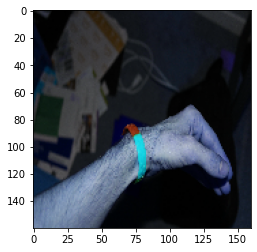

In [13]:

plt.imshow(X_train[5])
print(classes[np.argmax(y_train[5])])

trophy


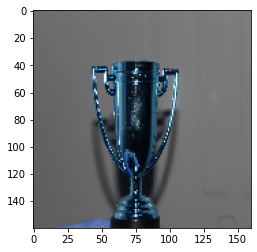

In [14]:
plt.imshow(X_test[5])
print(classes[np.argmax(y_test[5])])

In [15]:
evaluation_split = np.array(X_train), np.array(X_val), np.array(y_train), np.array(y_val)

In [16]:
print(y_train.shape[1])
print(X_train.shape, y_train.shape)

43
(3296, 160, 160, 3) (3296, 43)


In [17]:
print(y_val.shape[1])
print(X_val.shape, y_val.shape)

43
(824, 160, 160, 3) (824, 43)


In [18]:
print(y_test.shape[1])
print(X_test.shape, y_test.shape)

43
(104, 160, 160, 3) (104, 43)


In [19]:
y = to_categorical(y)

In [20]:
y_val[5]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

trophy


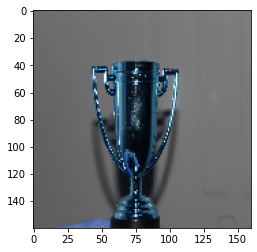

In [21]:
plt.imshow(X_test[5])
print(classes[np.argmax(y_test[5])])

In [22]:
def augment_data():
    """ Augments the data and returns a generator and the validation data and labels
    """
    # Boilerplate code. You can change this however you like.
    generator = ImageDataGenerator(
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rotation_range=360
                                   ).flow(X_train, y_train)
    return generator, X_test, y_test

In [23]:
# Toy usage example
from tensorflow.keras import models
from tensorflow.keras import layers 
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

mobilenet = MobileNetV2(input_shape=(160,160,3),
                    alpha=1.0,
                    include_top=False,
                    weights="imagenet",
                    input_tensor=None,
                    pooling=None
                    )
    
def build_toy_model():
    model = models.Sequential()

    model.add(mobilenet)
    # I tried unfreezing in the function below but it didnt work well
    for layer in model.layers[:1]:
      layer.trainable = False

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.35))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.45))
    model.add(layers.Dense(y_val.shape[1], activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return model


# First build and store


In [24]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

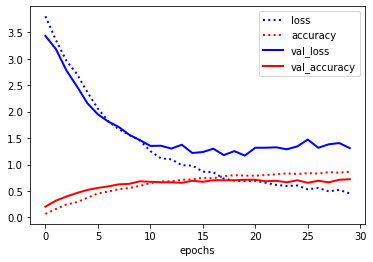

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               327936    
                                                                 
 dropout_4 (Dropout)         (None, 256)              

In [25]:
run_evaluation("toy_example", build_toy_model, augment_data(), 
               PATH_m, generator=True, epochs=100, steps_per_epoch=30,
               train=False)

In [26]:
from sklearn.metrics import accuracy_score

def evaluate_model(name):
    model = load_model_from_file(PATH_m, name, ".h5")
    preds = np.argmax(model.predict(X_test), axis=1)
    y_test_c = np.argmax(y_test,axis=1)
    print(f"The accuracy is: {accuracy_score(preds, y_test_c)}")
    return accuracy_score(preds, y_test_c)
test_accuracy_2_1 = evaluate_model("toy_example")


/content/drive/MyDrive/-Univ/2AMV10 Visual Analytics/2AMV10-group-16/toy_example.h5
The accuracy is: 0.9326923076923077


In [27]:
model = load_model_from_file(PATH_m, 'toy_example', '.h5')

/content/drive/MyDrive/-Univ/2AMV10 Visual Analytics/2AMV10-group-16/toy_example.h5


/content/drive/MyDrive/-Univ/2AMV10 Visual Analytics/2AMV10-group-16/toy_example.h5


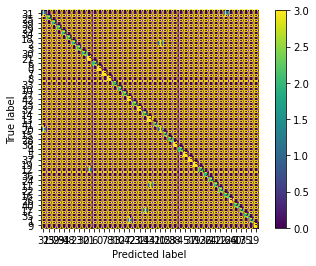

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix():
    model = load_model_from_file(PATH_m, "toy_example", ".h5")
    preds = np.argmax(model.predict(X_test), axis=1)
    y_test_c = np.argmax(y_test,axis=1)

    cm = ConfusionMatrixDisplay(confusion_matrix(y_test_c, preds), display_labels=classes)
    cm.plot()
    plt.show()
plot_confusion_matrix()

trophy


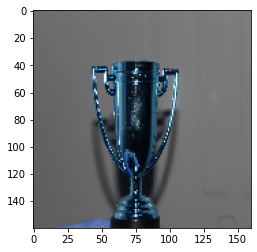

In [29]:
plt.imshow(X_test[5])
print(classes[np.argmax(y_test[5])])

/content/drive/MyDrive/-Univ/2AMV10 Visual Analytics/2AMV10-group-16/toy_example.h5
[ 3 25 55 56 60]
20 39
9 31
21 34
23 6
17 41


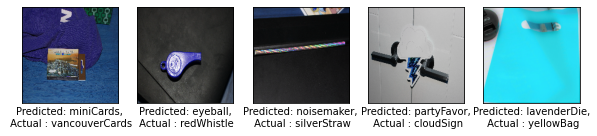

In [30]:
def plot_misclassifications():
    model = load_model_from_file(PATH_m, "toy_example", ".h5")
    y_pred = model.predict(X_test)
    misclassified_samples = np.nonzero(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))[0]

    fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
    print(misclassified_samples[:5])
    for nr, i in enumerate(misclassified_samples[:5]):
        axes[nr].imshow(X_test[i])
        print(np.argmax(y_pred[i]), np.argmax(y_test[i]))
        axes[nr].set_xlabel("Predicted: %s,\n Actual : %s" % (classes[np.argmax(y_pred[i])],classes[np.argmax(y_test[i])]))
        axes[nr].set_xticks(()), axes[nr].set_yticks(())

    plt.show()


plot_misclassifications()

paperPlate


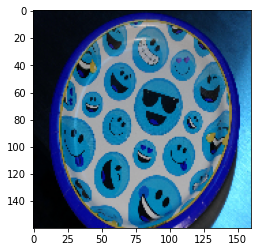

In [31]:
plt.imshow(X_test[0]);
print(classes[np.argmax(y_test[0])])


/content/drive/MyDrive/-Univ/2AMV10 Visual Analytics/2AMV10-group-16/toy_example.h5


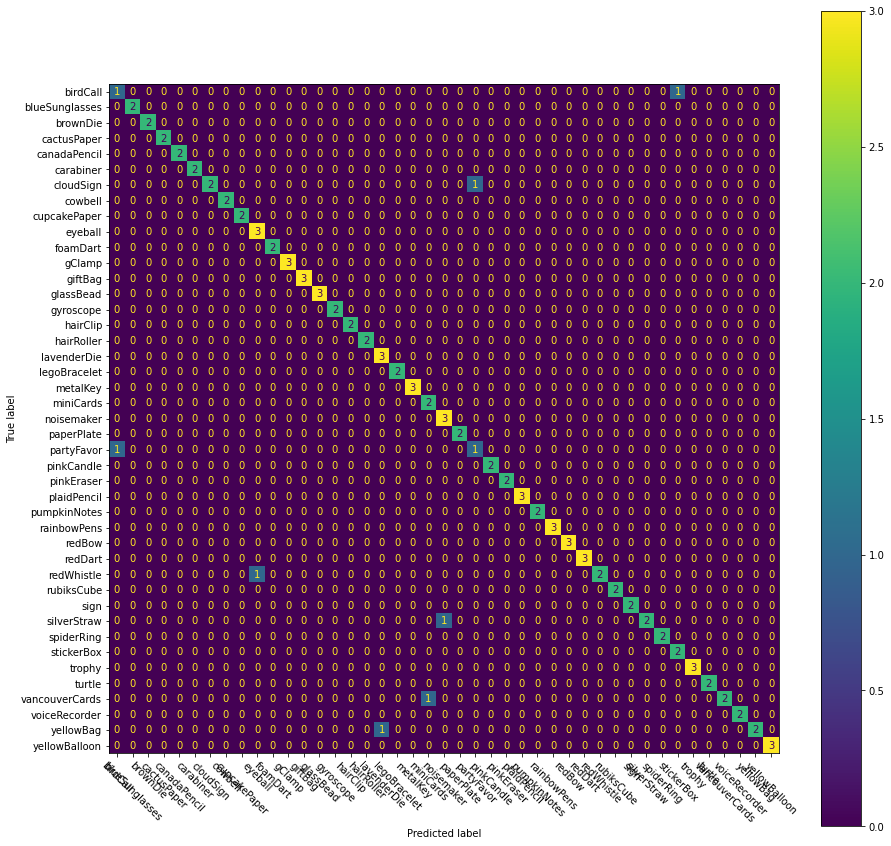

In [32]:
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def preds_to_json(test_set=X_test, plot=True):
  """
  Function does not return anything but makes a new file, plots if you want it to
  """
  
  X_test = test_set
  model = load_model_from_file(PATH_m, "toy_example", ".h5")
  preds = model.predict(X_test)

  a2 = np.argmax(preds, axis=1)
  a1 = np.argmax(y_test, axis=1)
  
  a_names = np.vectorize(classes.get)(a1)
  b_names = np.vectorize(classes.get)(a2)

  data = confusion_matrix(a_names, b_names)

  manual_dict = {}
  i = 0
  for col in data:
    colname = np.unique(a_names)[i]
    # print(colname)

    temp_dict = {str(colname) : data[i].tolist()}
    # print(temp_dict)
    manual_dict.update(temp_dict)
    i+=1

  with open('cm.json', 'w') as file:
      json.dump(manual_dict, file)

  if plot:
    cm = ConfusionMatrixDisplay(confusion_matrix(a_names, b_names), display_labels=np.unique(a_names))
    fig, ax = plt.subplots(figsize=(15,15))
    cm.plot(ax=ax)
    plt.xticks(rotation = -45)
    plt.show()

preds_to_json()

In [33]:
print(PATH_m)

/content/drive/MyDrive/-Univ/2AMV10 Visual Analytics/2AMV10-group-16


In [34]:
import time 
def read_test():

  """
        Reads the images of the person set and returns them as arrays X and y

        returns: X_t - array containing np-array-representation of images
                 captions - array containing corresponding text (if applicable)
                 person_n - person number associated with the images
  """

  # print(os.curdir)
  # os.chdir('../data/trainingData/TrainingImages')
  X_t = []
  captions = []
  person_n = []
  sys.path.insert(0, PATH_m)
  t_0 = time.perf_counter()
  path = "/content/drive/MyDrive/-Univ/2AMV10/2AMV10-group-16/data"
  i = 0
  limit = 100000
  for label in [name for name in os.listdir(path) if os.path.isdir(f"{path}/{name}")]:
      print(label)
      if not 'Person' in label:
        break
      t_1 = time.perf_counter()
      for image in [name for name in os.listdir(f"{path}/{label}")]:
          if image.endswith('.db') or image.endswith('.txt'):
            pass
            # skip captions for now
            # TODO get text out of file instead of filename
            # with open(f"{path}/{label}/{image}", "r") as f:
            #   print(image)
            #   print(f.readlines())
            #   captions.append(f.readlines())
          #X.append(cv2.imread(f"{path}/{label}/{image}"))
          else:
            t_6 = time.perf_counter()
            person_n.append(label)
            # print(image)
            X_t.append(process_img(cv2.imread(f"{path}/{label}/{image}")))
            t_2 = time.perf_counter()
            print(f"Doing image {image} took {t_2-t_6}")
            # print(label)
            i+= 1
          if i == limit:
              break
      if i == limit:
          break
      t_4 = time.perf_counter()
      print(f"Doing person : {label} took {t_4 - t_1}")
  t_3 = time.perf_counter()
  print(f"Done in {t_3-t_0}")  
  return np.array(X_t), captions, person_n#.reshape(50, 256*256), y, labels


# X_t, captions, person_n = read_test() # Run this line if you dont have the npy files yet. 
# save('X_t.npy', X_t) # Run this line if you dont have the npy files yet. 
# save('captions.npy', captions) # Run this line if you dont have the npy files yet. 
# save('person_n.npy', person_n) # Run this line if you dont have the npy files yet. 

In [35]:
""" This is the cell to use if you have already made the .npy files using the 
    cell above, or have downloaded those. If you do not have the npy files
    you need to create them from the original image dataset.
"""
# save('X_t.npy', X_t)
# save('captions.npy', captions)
# save('person_n.npy', person_n)

X_t = load('/content/drive/MyDrive/-Univ/2AMV10/2AMV10-group-16/X_t.npy')
captions = load('/content/drive/MyDrive/-Univ/2AMV10/2AMV10-group-16/captions.npy')
person_n = load('/content/drive/MyDrive/-Univ/2AMV10/2AMV10-group-16/person_n.npy')

# print(X.shape, y.shape)
# y=np.argmax(y,axis=1)

In [36]:
model = load_model_from_file(PATH_m, "toy_example", ".h5")
preds = model.predict(X_t)

a_names = np.vectorize(classes.get)(np.argmax(preds, axis=1))
a_names.shape

a_numbers = np.argmax(preds, axis=1)
predsnames = np.vectorize(classes.get)(np.argmax(preds, axis=1))

/content/drive/MyDrive/-Univ/2AMV10 Visual Analytics/2AMV10-group-16/toy_example.h5


eyeball


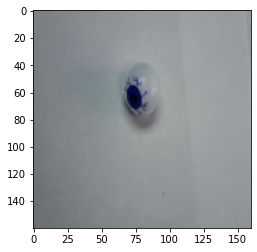

In [37]:
# Showing one image and its associated prediction
plt.imshow(X_t[3])
print(predsnames[3])

In [38]:
classes

{0: 'birdCall',
 1: 'blueSunglasses',
 2: 'brownDie',
 3: 'cactusPaper',
 4: 'canadaPencil',
 5: 'carabiner',
 6: 'cloudSign',
 7: 'cowbell',
 8: 'cupcakePaper',
 9: 'eyeball',
 10: 'foamDart',
 11: 'gClamp',
 12: 'giftBag',
 13: 'glassBead',
 14: 'gyroscope',
 15: 'hairClip',
 16: 'hairRoller',
 17: 'lavenderDie',
 18: 'legoBracelet',
 19: 'metalKey',
 20: 'miniCards',
 21: 'noisemaker',
 22: 'paperPlate',
 23: 'partyFavor',
 24: 'pinkCandle',
 25: 'pinkEraser',
 26: 'plaidPencil',
 27: 'pumpkinNotes',
 28: 'rainbowPens',
 29: 'redBow',
 30: 'redDart',
 31: 'redWhistle',
 32: 'rubiksCube',
 33: 'sign',
 34: 'silverStraw',
 35: 'spiderRing',
 36: 'stickerBox',
 37: 'trophy',
 38: 'turtle',
 39: 'vancouverCards',
 40: 'voiceRecorder',
 41: 'yellowBag',
 42: 'yellowBalloon'}

In [39]:
from itertools import groupby

alist = [i for i, j in groupby(person_n)]

blist = a_names

listofpreds = list(zip(person_n, a_numbers))

In [40]:
results = {}                              # use a normal dictionary for our output
for k, v in listofpreds:                    # the keys may be duplicates
    results.setdefault(k[6:], []).append(int(v))

In [41]:
with open('predsxtnumerical.json', 'w') as file:
      json.dump(results, file)
      
      

In [42]:
a_numbers = [int(x) for x in a_numbers]
# a_numbers

In [43]:
a_numbers = list(a_numbers)

In [44]:
listofpreds = list(zip(person_n, a_numbers))

In [45]:
def save_to_json(data, filename):
  with open(str(filename+'.json'), 'w') as file:
        json.dump(data, file)

In [46]:
save_to_json(listofpreds, 'predsxttuples')

In [78]:
# print(mobilenet.summary())
def plot_filters(img, layer_name):
  activation_model = models.Model(inputs=mobilenet.input, outputs=mobilenet.get_layer(str(layer_name)).output)
  activations = activation_model.predict(X_train[img].reshape(-1, 160, 160, 3))
  first_layer_activation = activations

  for i in range(0, first_layer_activation.shape[3]):
    if i == 32: # only way to prevent an error i was getting on line 12
      break 
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(X_train[img])
    ax2.matshow(first_layer_activation[0, :, :, i], cmap='viridis')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax1.set_xlabel('Input image')
    ax2.set_xlabel(f'Activation of filter {i+1}')
    plt.show()

plot_filters(42, 'Conv1')

Output hidden; open in https://colab.research.google.com to view.